In [15]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from itertools import product, compress
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")

PATH_DATA = "../datasets/SARS2/"
PATH_DATA_GHDDI = "../datasets/SAR1/GHDDI"

In [16]:
def get_features_RDKIT(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = {}
    fps = {}
    mols = {}
    error_mols = 0
    mol_names = set()
    for mol in structures_shared:
        if mol is None:
            error_mols += 1
            continue
        if mol.GetProp("_Name") in mol_names:
            continue
        name = int(mol.GetProp("_Name"))
        mol_names.add(name)
        AllChem.Compute2DCoords(mol)
        key = Chem.inchi.MolToInchiKey(mol)
        if (name, key) not in features:
            fp = Chem.RDKFingerprint(mol)           
            fps[(name, key)] = fp
            mols[(name, key)] = mol
            arr = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp,arr)
            # remove the first value which is added artificially
            features[(name, key)] = arr
    print(f"Found problems in {error_mols} molecules")
    return fps, features, mols

def get_molecules_from_data(features, fps, mols, data, id_column="Molecule_ID", structure_column="Standardized_Molecule_InChIKey", smiles_columns="Standardized_Molecule_Smiles", only_exact_matches=True, threshold_similarity=0.99):
    mol_ids = data[id_column]
    keys = data[structure_column]
    filtered_features = []
    filtered_fps = []
    filtered_mols = []
    filtered_bits = []
    mask = []
    unfound_structures = Chem.SDWriter(os.path.join(PATH_DATA, "molecules_missing.sdf"))
    for id_val in zip(mol_ids, keys):
        if id_val in features:
            mask.append(True)
            filtered_features.append(features[id_val])
            filtered_fps.append(fps[id_val])
            filtered_mols.append(mols[id_val])
        else:
            similar_mols = [k for k in features if k[0] == id_val[0]]
            if not similar_mols:
                print("Could not find molecules with id", id_val[0])
                mask.append(False)
                continue
            if only_exact_matches:
                mask.append(False)
                print(id_val)
                print(similar_mols)
            else:
                fps_similars = [fps[k] for k in similar_mols]
                smiles = data[(data[id_column] == id_val[0]) & (data[structure_column] == id_val[1])][smiles_columns].values[0]
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    if len(similar_mols) == 1:
                        mask.append(True)
                        filtered_features.append(features[similar_mols[0]])
                        filtered_fps.append(fps[similar_mols[0]])
                        filtered_mols.append(mols[similar_mols[0]])
                        continue
                    else:
                        mask.append(False)
                        print("Could not create molecule", id_val, "with smiles", smiles, "most similar", similar_mols)
                        continue
                mol.SetProp("_Name", str(id_val[0]))
                fp_mol = Chem.RDKFingerprint(mol)
                similarities = [DataStructs.TanimotoSimilarity(fp_mol, fp_possible) for fp_possible in fps_similars]
                # print(id_val)
                # print("Most similar molecules:")
                # for ids, sim in zip(similar_mols, similarities):
                    # print("\t", ids, sim)
                most_similar = np.argmax(similarities)
                if similarities[most_similar] > threshold_similarity:
                    # print("Selected: ", similar_mols[most_similar], similarities[most_similar])
                    mask.append(True)
                    filtered_features.append(features[similar_mols[most_similar]])
                    filtered_fps.append(fps[similar_mols[most_similar]])
                    filtered_mols.append(mols[similar_mols[most_similar]])
                else:
                    unfound_structures.write(mol)
                    print(id_val)
                    for ids, sim in zip(similar_mols, similarities):
                        print("\t", ids, sim)
                    mask.append(False)
    return np.array(filtered_features), filtered_fps, filtered_mols, mask

def convert_IC50_to_um(data, col_values, col_units):
    new_vals = []
    for val, unit in zip(data[col_values], data[col_units]):
        if unit == "nM":
            new_vals.append(val/1000)
        elif unit == "µM":
            new_vals.append(val)
        else:
            raise ValueError(f"{unit} unit not found!")
    data[col_values] = new_vals
    data[col_units] = "µM"
    return data

def filter_duplicates(data, col_id, col_structure):
    dup = data.duplicated(subset=[col_id, col_structure], keep=False)
    to_remove = []
    for id_val in data[dup][col_id].unique():
        dup_data = data[data[col_id] == id_val]
        if len(set(dup_data["Is_active"])) != 1:
            to_remove.append(id_val)
    rm_masks = data[col_id].isin(to_remove)
    data = data[~rm_masks]
    return data, rm_masks

In [17]:
fps_SARS2, features_SARS2, mols_SARS2 = get_features_RDKIT(os.path.join(PATH_DATA, "SIM_Broad_MProResults_ligprep_maestro.sd"))

RDKit WARNING: [18:24:41] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [18:24:41] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [18:24:41] ERROR: Could not sanitize molecule ending on line 15167
RDKit ERROR: [18:24:41] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [18:24:41] ERROR: Could not sanitize molecule ending on line 15269
RDKit ERROR: [18:24:41] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [18:24:41] ERROR: Could not sanitize molecule ending on line 15371
RDKit ERROR: [18:24:41] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [18:24:41] ERROR: Could not sanitize molecule ending on line 15473
RDKit ERROR: [18:24

Found problems in 8 molecules


In [18]:
threshold_activity = 20 # uM
data_orig_broad = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-broad.csv"), decimal=",")
data_orig_dompe = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-dompe.csv"), decimal=",")
data_orig_broad = data_orig_broad.rename(columns={"NAME": "Name",
                                                  "3CL-Pro IC50-15min (µM) (triplicates)": "IC50 µM 15 min",
                                                  "3CLpro\n IC50 slope (µM) (triplicates)": "IC50 µM slope"})
data_orig_dompe = data_orig_dompe.rename(columns={"IC50 µM\n 15 min\n (red manually confirmed)": "IC50 µM 15 min",
                                                  "IC50 µM\n slope\n (red manually confirmed)": "IC50 µM slope"})
data_SARS2 = pd.concat([data_orig_broad, data_orig_dompe])

correspondance_broad = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_broad.csv"), decimal=",")
correspondance_broad = correspondance_broad.rename(columns={"Molecule_id": "Molecule_ID"})
correspondance_dompe = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_dompe.csv"), decimal=",")
correspondance = pd.concat([correspondance_broad, correspondance_dompe])
correspondance = correspondance.rename(columns={"Fraunofer Compound Id": "Compound Id"})
data_SARS2 = data_SARS2.merge(correspondance, how="inner", on="Compound Id")

In [19]:
data_SARS2["Is_active"] = (data_SARS2["IC50 µM 15 min"] < threshold_activity).values.astype(int)
print(data_SARS2.shape)

(191, 32)


In [20]:
dup = data_SARS2.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
all_dup = data_SARS2.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep=False)
data_SARS2 = data_SARS2[~dup]
print(data_SARS2.shape)

Found 10 duplicated entries
(181, 32)


In [21]:
data_SARS2[all_dup]

/home/jfrancesc/miniconda3/envs/drug_learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Compound Id,Name,DTT sensitivity (if > 30 % loss of activity at 20 µM),Inhibition [%] Primary Screen (single point; 20 µM),"HC\nInhibition [%] (triplicate, 20 µM)","HC\n AV Inhibition [%] (triplicate, 20 µM)\nslope",AV inhibition +DTT 15min \nduplicates,IC50 µM 15 min,IC50 µM slope,%inhibition_d03-KU_LW,...,AV Inhibiton\n 15min,%Inhibition\n_slope PS,%Inhibition\n_15min PS,VeroE6% \nConfluence_d03,VeroE6 % \nInhibition_d03,Chemically reactive?,Molecule_ID,Standardized_Molecule_InChIKey,Standardized_Molecule_Smiles,Is_active
8,SPE_K81330143,Tideglusib,sensitiv,90.94,99.30,99.28,-4.89,0.15,0.14,-3.46,...,NaN,NaN,NaN,NaN,NaN,NaN,3878,PMJIHLSCWIDGMD-UHFFFAOYSA-N,O=C1SN(C(=O)N1Cc2ccccc2)c3cccc4ccccc34,1
9,SPE_K34149328,bonaphthone,sensitiv,95.47,99.37,100.31,37.44,0.16,0.38,-1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,4448,MXWZRRPNVLCHMY-UHFFFAOYSA-N,Brc1ccc2C(=O)C(=O)C=Cc2c1,1
30,SPE_K86972824,OLTIPRAZ,sensitiv,93.83,97.56,101.75,1.56,0.62,1.44,6.11,...,NaN,NaN,NaN,NaN,NaN,NaN,8437,CKNAQFVBEHDJQV-UHFFFAOYSA-N,CC1=C(SSC1=S)c2cnccn2,1
33,SPE_K55591206,(-)-Epigallocatechin Gallate,sensitiv,95.26,98.89,97.04,-22.36,0.72,1.29,-1.41,...,NaN,NaN,NaN,NaN,NaN,NaN,522,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@H...,1
38,SPE_K68408467,PROFLAVINE HEMISULFATE,sensitiv,60.89,76.55,99.87,20.41,0.83,2.02,19.09,...,NaN,NaN,NaN,NaN,NaN,NaN,6835,WDVSHHCDHLJJJR-UHFFFAOYSA-N,Nc1ccc2cc3ccc(N)cc3nc2c1,1
58,SPE_M87138257,Acriflavine hydrochloride,Acriflavine hydrochloride,59.00,67.97,99.10,68.22,1.93,5.10,-26.74,...,NaN,NaN,NaN,NaN,NaN,NaN,6864,NLROCEWTIPMDKX-UHFFFAOYSA-N,C[N]1=C2C=C(N)C=CC2=Cc3ccc(N)cc13,1
74,SPE_K20313525,rosmarinic-acid,sensitiv,95.67,94.92,94.14,-17.76,3.86,4.96,8.26,...,NaN,NaN,NaN,NaN,NaN,NaN,8605,DOUMFZQKYFQNTF-WUTVXBCWSA-N,OC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)\C=C\c2ccc(...,1
95,SPE_A49172652,LANSOPRAZOLE,sensitiv,97.15,98.57,96.07,-12.10,7.25,10.83,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,348,MJIHNNLFOKEZEW-UHFFFAOYSA-N,Cc1c(OCC(F)(F)F)ccnc1CS(=O)c2nc3ccccc3[nH]2,1
112,SPE_K76841105,Tazarotene (Avage),Tazarotene (Avage),-880.10,-692.49,108.07,-663.39,13.50,321.75,-2.40,...,NaN,NaN,NaN,NaN,NaN,NaN,445,OGQICQVSFDPSEI-UHFFFAOYSA-N,CCOC(=O)c1ccc(nc1)C#Cc2ccc3SCCC(C)(C)c3c2,1
137,SPE_K33623053,Rose Bengal Sodium Salt,Rose Bengal Sodium Salt,99.60,74.85,-2.27,69.98,1176.55,26.97,22.43,...,NaN,NaN,NaN,NaN,NaN,NaN,5272,IICCLYANAQEHCI-UHFFFAOYSA-N,Oc1c(I)cc2c(Oc3c(I)c(O)c(I)cc3C24OC(=O)c5c(Cl)...,0


In [22]:
features_SARS2, fps_SARS2, mols_SARS2, mask = get_molecules_from_data(features_SARS2, fps_SARS2, mols_SARS2, data_SARS2, only_exact_matches=False, threshold_similarity=0.2)
data_filtered = data_SARS2[mask]
active_SARS2 = data_filtered["Is_active"].values
print(sum(mask))

Could not find molecules with id 11947
Could not find molecules with id 12210
Could not find molecules with id 10107
Could not find molecules with id 7168
(6835, 'WDVSHHCDHLJJJR-UHFFFAOYSA-N')
	 (6835, 'IHRJICSCSWHANS-UHFFFAOYSA-N') 0.14022988505747128
Could not find molecules with id 11215
Could not find molecules with id 10484
Could not find molecules with id 10913
Could not find molecules with id 12105
Could not find molecules with id 11495
Could not find molecules with id 6326
Could not find molecules with id 10781
Could not find molecules with id 11917
Could not find molecules with id 10766
Could not find molecules with id 12364
(10817, 'PSFDQSOCUJVVGF-UHFFFAOYSA-N')
	 (10817, 'FLJHILGVZZUAHY-UHFFFAOYSA-N') 0.1834862385321101


RDKit ERROR: [18:24:41] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [18:24:41] Explicit valence for atom # 3 N, 4, is greater than permitted


165


Load GHDDI data set

In [23]:
data_GHDDI_orig = pd.read_csv(os.path.join(PATH_DATA_GHDDI, "3CLProtease_ActiveDataset.csv"), decimal=",")
activity_col = "value_GHDDI"
measures_col = "parameter_GHDDI"
units_col = "unit_GHDDI"
id_col = "Molecule_ID"

In [24]:
data_GHDDI = data_GHDDI_orig.dropna(subset=[activity_col, id_col]).copy()
data_GHDDI[id_col] = data_GHDDI[id_col].astype(int)
data_GHDDI = data_GHDDI[data_GHDDI[measures_col] == "IC50"]
dup = data_GHDDI.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
data_GHDDI = data_GHDDI[~dup]
data_GHDDI.shape

Found 0 duplicated entries


(401, 33)

Convert all experimental values to micromolar

In [25]:
data_GHDDI = convert_IC50_to_um(data_GHDDI, activity_col, units_col)
data_GHDDI["Is_active"] = (data_GHDDI[activity_col] < threshold_activity).values.astype(int)

In [26]:
fps_rdkit_GHDDI, features_rdkit_GHDDI, mols_rdkit_GHDDI = get_features_RDKIT(os.path.join(PATH_DATA_GHDDI, "3C-like_protease_GHDDI_ligprep_maestro.sdf"))

RDKit WARNING: [18:24:42] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [18:24:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:24:42] ERROR: Could not sanitize molecule ending on line 11557
RDKit WARNING: [18:24:42] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [18:24:42] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [18:24:42] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [18:24:42] ERROR: Could not sanitize molecule ending on line 85833
RDKit ERROR: [18:24:42] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [18:24:42] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [18:24:42] ERROR: Could not sanitize molecule ending on line 86055
RDKit ERROR: [18:24:42] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [18:24:42] Explicit valence for atom

Found problems in 8 molecules


RDKit WARNING: [18:24:43] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [18:24:43] Warning: molecule is tagged as 3D, but all Z coords are zero


In [27]:
features_GHDDI, fps_GHDDI, mols_GHDDI, mask_GHDDI = get_molecules_from_data(features_rdkit_GHDDI, fps_rdkit_GHDDI, mols_rdkit_GHDDI, data_GHDDI, only_exact_matches=False, threshold_similarity=0.2)
data_GHDDI = data_GHDDI[mask_GHDDI]
active_SARS1 = data_GHDDI["Is_active"].values
print(data_GHDDI.shape, sum(mask_GHDDI))

RDKit ERROR: [18:24:42] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 8 N, 4, is greater than permitted


Could not find molecules with id 9602


RDKit ERROR: [18:24:43] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [18:24:43] Explicit valence for atom # 9 N, 4, is greater than permitted


(400, 34) 400


In [28]:
sources = ["SARS2" for _ in fps_SARS2]+["SARS1" for _ in fps_GHDDI]
joined_sets = pd.concat([data_filtered, data_GHDDI], ignore_index=True)
joined_features = np.vstack((features_SARS2, features_GHDDI))
joined_fps = fps_SARS2+fps_GHDDI
joined_mols = mols_SARS2+mols_GHDDI
joined_sets, mask_to_rm = filter_duplicates(joined_sets, id_col, "Standardized_Molecule_InChIKey")
joined_features = joined_features[~mask_to_rm]
joined_fps = list(compress(joined_fps, ~mask_to_rm))
joined_mols = list(compress(joined_mols, ~mask_to_rm))
joined_sources = list(compress(sources, ~mask_to_rm))
active = joined_sets["Is_active"].values
fw = Chem.SDWriter(os.path.join(PATH_DATA, "molecules_cleaned_SARS1_SARS2_rdkit.sdf"))
for mol in joined_mols:
    fw.write(mol)
joined_sets.to_csv(os.path.join(PATH_DATA, "dataset_cleaned_SARS1_SARS2_rdkit.csv"), index=False)
np.save(os.path.join("features", "SARS1_SARS2", "RDKIT.npy"), joined_features)
np.save(os.path.join("features", "SARS2", "RDKIT.npy"), features_SARS2)
np.save(os.path.join("features", "SARS1", "RDKIT.npy"), features_GHDDI)
print(joined_sets.shape, len(joined_fps), len(joined_mols), joined_features.shape)

(563, 62) 563 563 (563, 2048)


Actives 310, 55.06%; Inactives 253, 44.94%


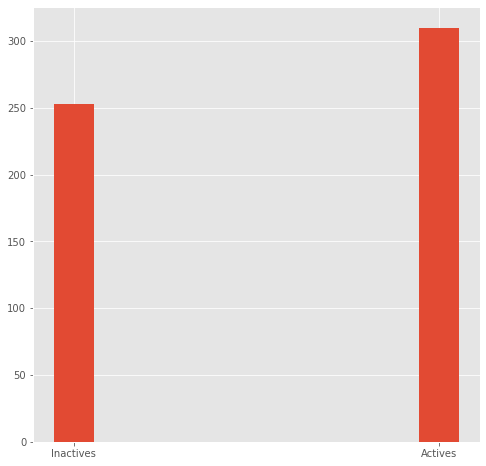

In [38]:
plt.figure(figsize=(8,8))
plt.hist(active, bins=10);
plt.xticks([0.05, 0.95], ["Inactives", "Actives"])
n_active = sum(active)
n_inactive = len(active)-n_active
print(f"Actives {n_active}, {100*n_active/(n_active+n_inactive):.2f}%; Inactives {n_inactive}, {100*n_inactive/(n_active+n_inactive):.2f}%")

In [39]:
def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    f, ax = plt.subplots(1, 1)
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()
    
def grid_search_SVM(train_data, test_data, train_labels, test_labels, max_gamma=1, min_gamma=0.001, max_C=100, min_C=0.01, n_points=30):
    accuracy = []
    MCCs = []
    C_values = np.geomspace(min_C, max_C, num=n_points)
    gamma_values = np.geomspace(min_gamma, max_gamma, num=n_points)
    for c_val in C_values:
        acc = []
        mcc = []
        for gamma in gamma_values:
            svm = SVC(C=c_val, kernel="rbf", gamma=gamma)
            svm.fit(train_data, train_labels)
            predictions = svm.predict(test_data)
            print(f"C={c_val}, gamma={gamma}")
            vals = print_metrics(predictions, test_labels)
            acc.append(vals[0])
            mcc.append(vals[1])
        accuracy.append(acc)
        MCCs.append(mcc)

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(MCCs, annot=False, ax = ax, cmap="Greens")
    ax.set_yticklabels(np.round(C_values, 2), rotation=0)
    ax.set_xticklabels(np.round(gamma_values, 2), rotation=90)
    ax.set_ylabel("C value")
    ax.set_xlabel(r"$\gamma$")
    plt.show()

In [40]:
train_data, test_data, train_labels, test_labels = train_test_split(joined_features, active, test_size=0.25, random_state=42, stratify=active)

NER: 0.713, Sensitivity or recall: 0.808, Specificity: 0.619, Precision: 0.724, Correctly classified: 0.723, MCC: 0.436


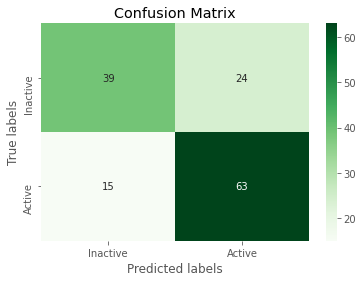

In [41]:
clf = DecisionTreeClassifier(random_state=42, class_weight="balanced")
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

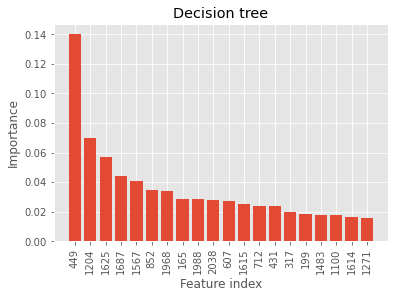

In [42]:
order_dt = np.argsort(clf.feature_importances_)[::-1]
x = np.array(range(len(clf.feature_importances_)))[:20]
plt.bar(x, clf.feature_importances_[order_dt][:20])
plt.xticks(x, order_dt[:20], rotation=90);
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Decision tree");

NER: 0.760, Sensitivity or recall: 0.885, Specificity: 0.635, Precision: 0.750, Correctly classified: 0.773, MCC: 0.542


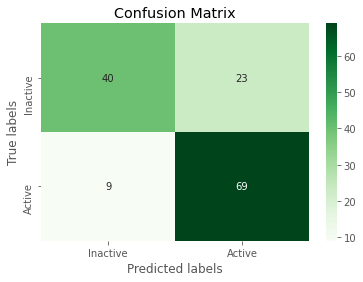

In [43]:
clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

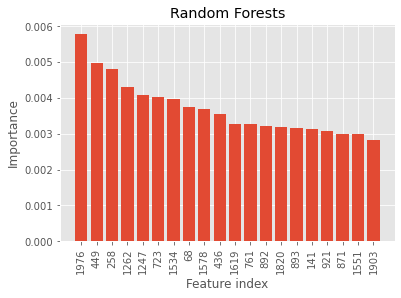

In [44]:
order_RF = np.argsort(clf.feature_importances_)[::-1]
x = np.array(range(len(clf.feature_importances_)))[:20]
plt.bar(x, clf.feature_importances_[order_RF][:20])
plt.xticks(x, order_RF[:20], rotation=90);
plt.xlabel("Feature index")
plt.ylabel("Importance")
plt.title("Random Forests");

In [45]:
# come from highest correlation to labels using chi-2 and mutual information
best = list(set(order_dt[:20]) & set(order_RF[:20]))
print(best)

[449]


We test a similar approach with the SARS2 data set only

In [46]:
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(features_SARS2, active_SARS2, test_size=0.25, random_state=42, stratify=active_SARS2)

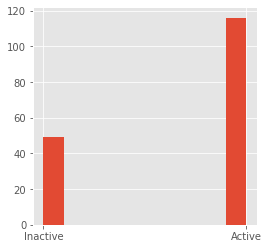

In [47]:
plt.figure(figsize=(4,4))
plt.hist(active_SARS2, bins=10);
plt.xticks([0, 1], ["Inactive", "Active"]);

NER: 0.542, Sensitivity or recall: 1.000, Specificity: 0.083, Precision: 0.732, Correctly classified: 0.738, MCC: 0.247


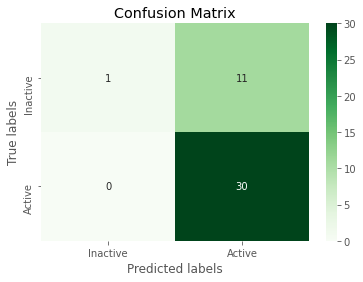

In [48]:
C= 7.8804628
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(train_data2, train_labels2)
predictions = svm.predict(test_data2)
vals = print_metrics(predictions, test_labels2)
plot_confusion(predictions, test_labels2)

Try with the SARS1 data set only

In [49]:
train_data1, test_data1, train_labels1, test_labels1 = train_test_split(features_GHDDI, active_SARS1, test_size=0.25, random_state=42, stratify=active_SARS1)

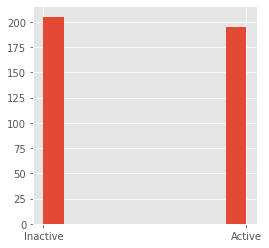

In [50]:
plt.figure(figsize=(4,4))
plt.hist(active_SARS1, bins=10);
plt.xticks([0, 1], ["Inactive", "Active"]);

NER: 0.757, Sensitivity or recall: 0.592, Specificity: 0.922, Precision: 0.879, Correctly classified: 0.760, MCC: 0.546


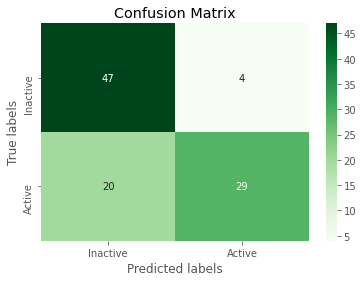

In [51]:
C= 4.17531
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(train_data1, train_labels1)
predictions = svm.predict(test_data1)
vals = print_metrics(predictions, test_labels1)
plot_confusion(predictions, test_labels1)

Train with SARS1, test with SARS2 

NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.297, MCC: nan


<ipython-input-39-d75c9e15214a>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


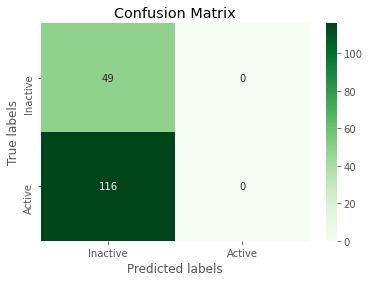

In [52]:
C= 8.53
gamm = 0.05
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_GHDDI, active_SARS1)
predictions = svm.predict(features_SARS2)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

Similar but adding class weights

NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.297, MCC: nan


<ipython-input-39-d75c9e15214a>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


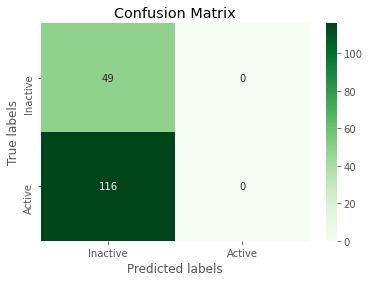

In [53]:
C= 8.53
gamm = 0.05
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_GHDDI, active_SARS1)
predictions = svm.predict(features_SARS2)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

Train with SARS2, test with SARS1

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.487, Correctly classified: 0.487, MCC: nan


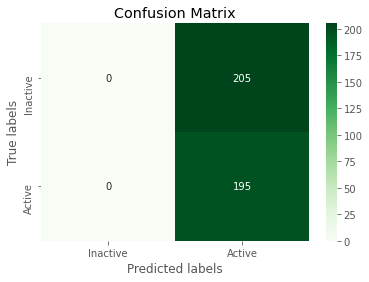

In [54]:
C= 1.172102
gamm = 0.0239
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(features_SARS2, active_SARS2)
predictions = svm.predict(features_GHDDI)
vals = print_metrics(predictions, active_SARS1)
plot_confusion(predictions, active_SARS1)

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.487, Correctly classified: 0.487, MCC: nan


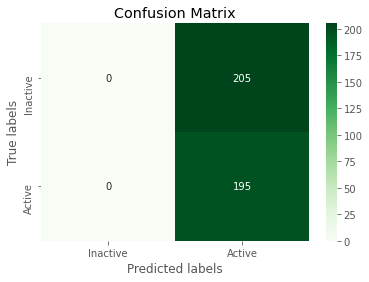

In [55]:
C= 1.172102
gamm = 0.0239
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
svm.fit(features_SARS2, active_SARS2)
predictions = svm.predict(features_GHDDI)
vals = print_metrics(predictions, active_SARS1)
plot_confusion(predictions, active_SARS1)

Try 10-fold cross validation with the full data set 

In [56]:
def run_cross_validation(features, labels, folds=5, iters=10, clf=RandomForestClassifier(random_state=42, class_weight="balanced"), verbose=True):
    MCCs_val = []
    MCCs_test = []
    accs_val = []
    accs_test = []
    for i in range(iters):
        training_set, testing_set, training_labels, testing_labels = train_test_split(features, labels, test_size=0.25, random_state=i, stratify=labels)
        skf = StratifiedKFold(n_splits=folds)
        for i, (train_index, test_index) in enumerate(skf.split(training_set, training_labels)):
            train_data, val_data = training_set[train_index], training_set[test_index]
            train_labels, val_labels = training_labels[train_index], training_labels[test_index]
            if verbose:
                print(f"Calculating with fold {i}")
            clf.fit(train_data, train_labels)
            predictions = clf.predict(val_data)
            val_acc, val_mcc = print_metrics(predictions, val_labels, verbose=verbose)
            if verbose:
                plot_confusion(predictions, test_labels)
            MCCs_val.append(val_mcc)
            accs_val.append(val_acc)
        clf.fit(training_set, training_labels)
        predictions = clf.predict(testing_set)
        test_acc, test_mcc = print_metrics(predictions, testing_labels, verbose=verbose)
        accs_test.append(test_acc)
        MCCs_test.append(test_mcc)
    return MCCs_val, MCCs_test, accs_val, accs_test

def plot_results_CV(MCCs_val, MCCs_test, accs_val, accs_test, y_lims=None):
    MCCs_val = np.array(MCCs_val)
    MCCs_val[np.isnan(MCCs_val)] = 0
    MCCs_test = np.array(MCCs_test)
    MCCs_test[np.isnan(MCCs_test)] = 0
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    ax[0].boxplot([np.array(accs_val)[~np.isnan(accs_val)], np.array(accs_test)[~np.isnan(accs_test)]], labels=["Validation", "Testing"])
    ax[1].boxplot([MCCs_val, MCCs_test], labels=["Validation", "Testing"])
    if y_lims is not None:
        ax[0].set_ylim(top=y_lims[1], bottom=y_lims[0])
        ax[1].set_ylim(top=y_lims[1], bottom=y_lims[0])
    else:
        y_min = -0.1+np.nanmin([np.nanmin(accs_val), np.nanmin(accs_test), np.nanmin(MCCs_val), np.nanmin(MCCs_test)])
        y_max = 0.1+np.nanmax([np.nanmax(accs_val), np.nanmax(accs_test), np.nanmax(MCCs_val), np.nanmax(MCCs_test)])
        ax[0].set_ylim(top=y_max, bottom=y_min)
        ax[1].set_ylim(top=y_max, bottom=y_min)
    ax[0].set_ylabel("Accuracy")
    ax[1].set_ylabel("MCC")

In [57]:
C= 4.17531
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
MCC_val_svm, MCC_test_svm, acc_val_svm, acc_test_svm = run_cross_validation(joined_features, active, folds=10, verbose=False, clf=svm)

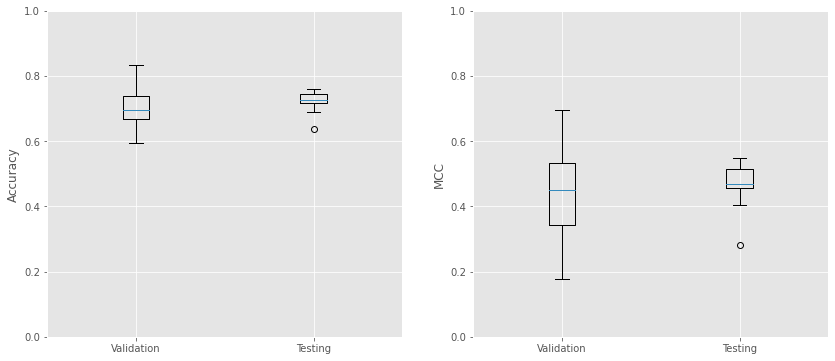

In [58]:
plot_results_CV(MCC_val_svm, MCC_test_svm, acc_val_svm, acc_test_svm, y_lims=(0, 1))

In [59]:
model = DecisionTreeClassifier(random_state=42)
MCC_val_tree, MCC_test_tree, acc_val_tree, acc_test_tree = run_cross_validation(joined_features, active, folds=10, verbose=False, clf=model)

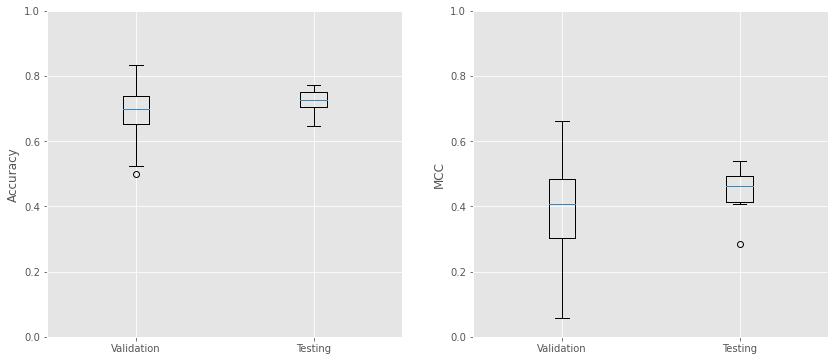

In [60]:
plot_results_CV(MCC_val_tree, MCC_test_tree, acc_val_tree, acc_test_tree, y_lims=(0, 1))

In [61]:
MCC_train_RF, MCC_test_RF, acc_train_RF, acc_test_RF = run_cross_validation(joined_features, active, folds=10, verbose=False)

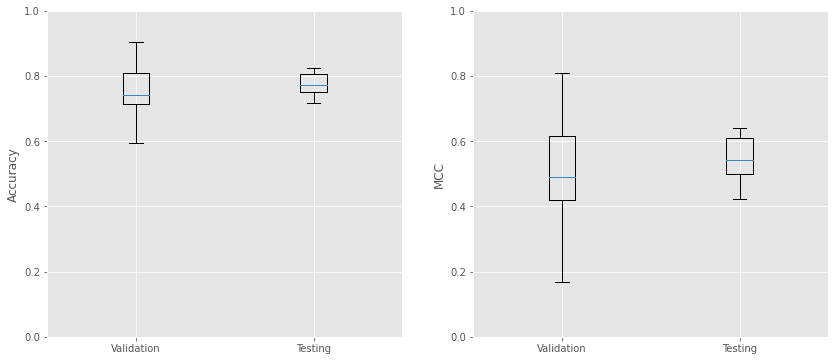

In [62]:
plot_results_CV(MCC_train_RF, MCC_test_RF, acc_train_RF, acc_test_RF, y_lims=(0, 1))

In [63]:
percentiles = list(range(1,101,5))
n_features = []
MCCs = []
accs = []
skf = StratifiedKFold(n_splits=10)
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    transform_features = feat_select.fit_transform(joined_features, active)
    n_features.append(transform_features.shape[1])
    mcc_CV = []
    acc_CV = []
    for i, (train_index, test_index) in enumerate(skf.split(transform_features, active)):
        train_data, test_data = transform_features[train_index], transform_features[test_index]
        train_labels, test_labels = active[train_index], active[test_index]
        print(f"Calculating with fold {i}, percentile {percentile}")
        clf = RandomForestClassifier(random_state=42)
        clf.fit(train_data, train_labels)
        predictions = clf.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        mcc_CV.append(test_mcc)
        acc_CV.append(test_acc)
    MCCs.append(mcc_CV)
    accs.append(acc_CV)

Calculating with fold 0, percentile 1
NER: 0.406, Sensitivity or recall: 0.581, Specificity: 0.231, Precision: 0.474, Correctly classified: 0.421, MCC: -0.199
Calculating with fold 1, percentile 1
NER: 0.547, Sensitivity or recall: 0.710, Specificity: 0.385, Precision: 0.579, Correctly classified: 0.561, MCC: 0.100
Calculating with fold 2, percentile 1
NER: 0.782, Sensitivity or recall: 0.871, Specificity: 0.692, Precision: 0.771, Correctly classified: 0.789, MCC: 0.576
Calculating with fold 3, percentile 1
NER: 0.503, Sensitivity or recall: 0.645, Specificity: 0.360, Precision: 0.556, Correctly classified: 0.518, MCC: 0.005
Calculating with fold 4, percentile 1
NER: 0.764, Sensitivity or recall: 0.968, Specificity: 0.560, Precision: 0.732, Correctly classified: 0.786, MCC: 0.592
Calculating with fold 5, percentile 1
NER: 0.808, Sensitivity or recall: 0.935, Specificity: 0.680, Precision: 0.784, Correctly classified: 0.821, MCC: 0.646
Calculating with fold 6, percentile 1
NER: 0.920, S

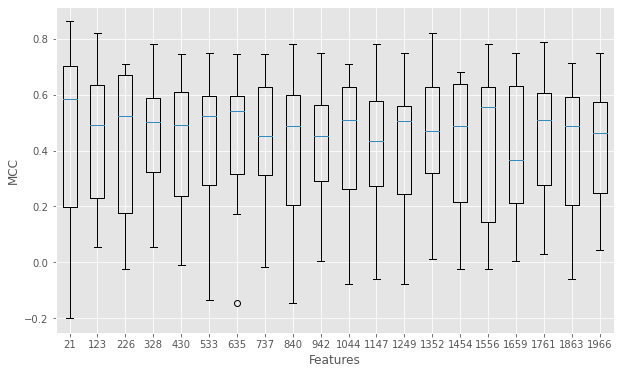

In [64]:
plt.figure(figsize=(10, 6))
plt.boxplot(MCCs, labels=n_features)
plt.ylabel("MCC")
plt.xlabel("Features");

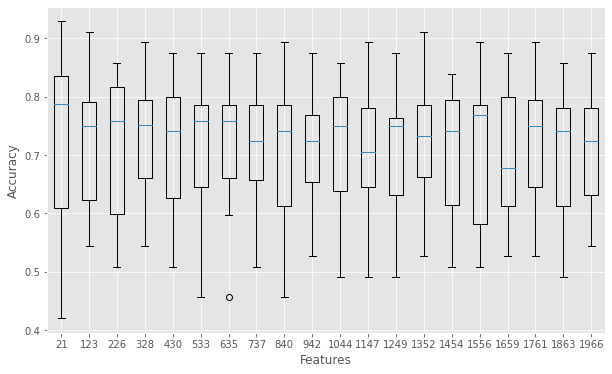

In [65]:
plt.figure(figsize=(10, 6))
plt.boxplot(accs, labels=n_features)
plt.ylabel("Accuracy")
plt.xlabel("Features");

We use now cross validation with the SARS2 set only and then use SARS1 as test set, with a Random Forest

In [66]:
# features_full, features_GHDDI, active_SARS2, active_SARS1
MCC_val12, MCC_test12, acc_val12, acc_test12 = run_cross_validation(features_SARS2, active_SARS2, folds=5, verbose=False)

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


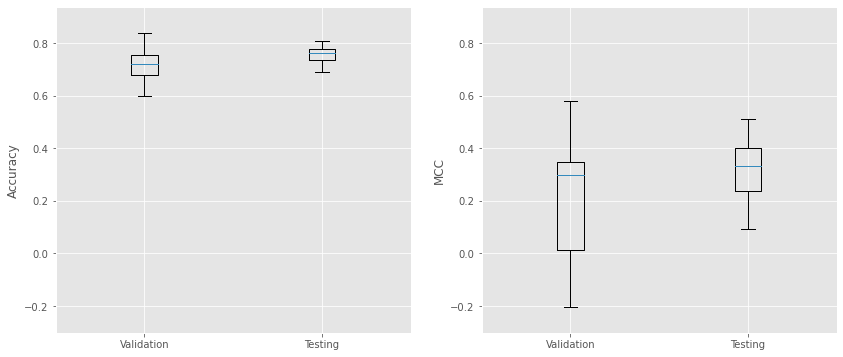

In [67]:
plot_results_CV(MCC_val12, MCC_test12, acc_val12, acc_test12)

And use CV with SARS1 to test with SARS 2

In [68]:
MCC_val12, MCC_test12, acc_val12, acc_test12 = run_cross_validation(features_GHDDI, active_SARS1, folds=10, verbose=False)

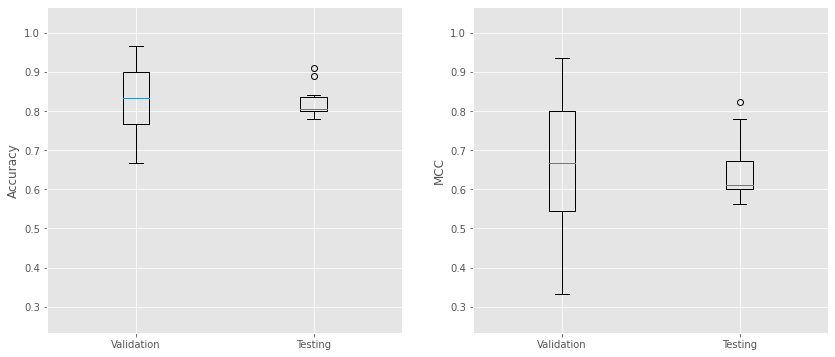

In [69]:
plot_results_CV(MCC_val12, MCC_test12, acc_val12, acc_test12)

We now keep only the features selected from the combination of mutual information, chi-squared and the most important features from a decision tree and random forest

In [70]:
best_features = joined_features[:, best]
best_features_SARS2 = features_SARS2[:, best]
best_features_SARS1 = features_GHDDI[:, best]
print(best_features.shape)

(563, 1)


In [71]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

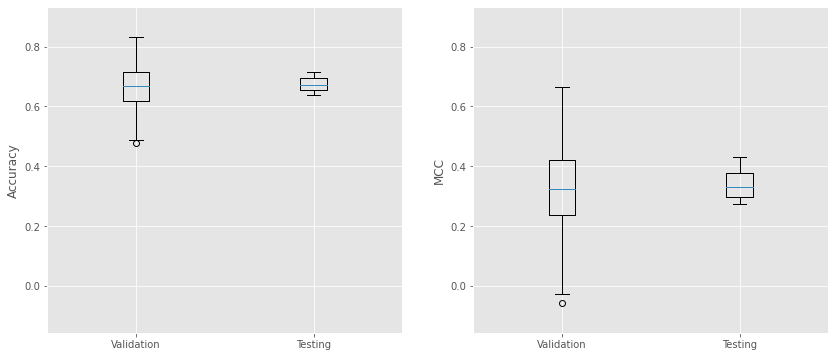

In [72]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

In [73]:
model = RandomForestClassifier(random_state=42, n_estimators=1)
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

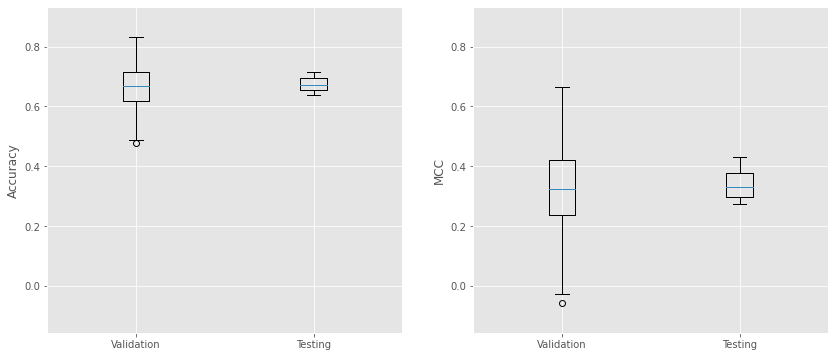

In [74]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

In [75]:
model = DecisionTreeClassifier(random_state=42)
MCC_val_all_tree, MCC_test_all_tree, acc_val_all_tree, acc_test_all_tree = run_cross_validation(best_features, active, clf=model, folds=10, verbose=False)

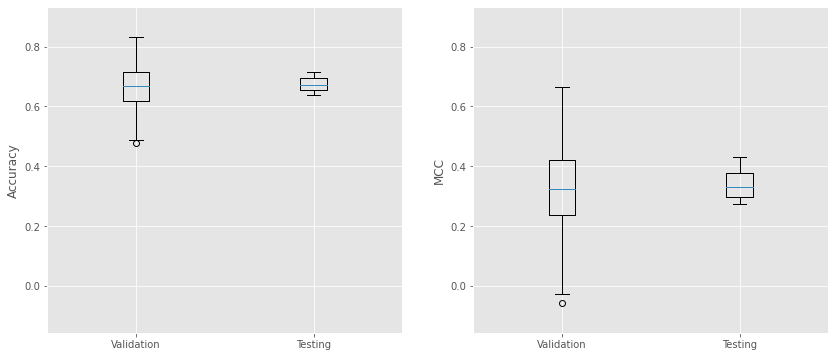

In [76]:
plot_results_CV(MCC_val_all_tree, MCC_test_all_tree, acc_val_all_tree, acc_test_all_tree)

Try with SVM

In [77]:
C= 4.17531
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
MCC_val_svm, MCC_test_svm, acc_val_svm, acc_test_svm = run_cross_validation(best_features, active, folds=10, verbose=False, clf=svm)

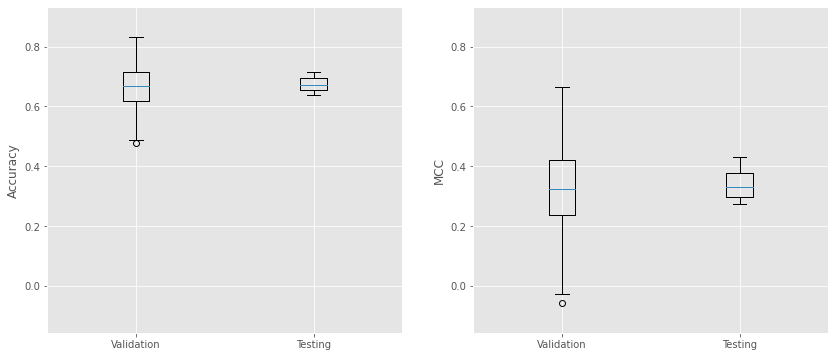

In [78]:
plot_results_CV(MCC_val_svm, MCC_test_svm, acc_val_svm, acc_test_svm)

Use only SARS2 set

In [79]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features_SARS2, active_SARS2, clf=model, folds=5, verbose=False)

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

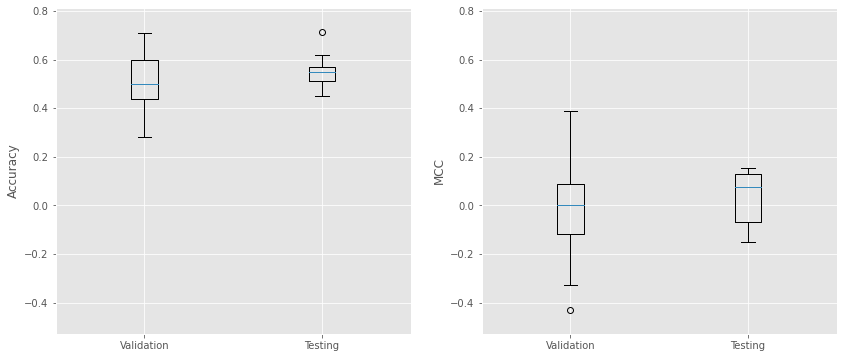

In [80]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

Use only SARS1 set

In [81]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features_SARS1, active_SARS1, clf=model, folds=10, verbose=False)

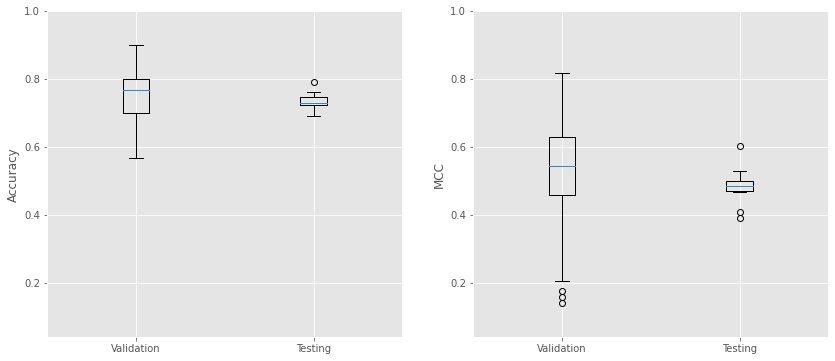

In [82]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

In [83]:
n_features = []
MCCs = []
accs = []
skf = StratifiedKFold(n_splits=10)
for n in range(1, len(best)):
    feat_select = SelectKBest(chi2, k=n)
    transform_features = feat_select.fit_transform(best_features, active)
    n_features.append(transform_features.shape[1])
    mcc_CV = []
    acc_CV = []
    for i, (train_index, test_index) in enumerate(skf.split(transform_features, active)):
        train_data, test_data = transform_features[train_index], transform_features[test_index]
        train_labels, test_labels = active[train_index], active[test_index]
        print(f"Calculating with fold {i}, percentile {percentile}")
        clf = DecisionTreeClassifier(random_state=42)
        clf.fit(train_data, train_labels)
        predictions = clf.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        mcc_CV.append(test_mcc)
        acc_CV.append(test_acc)
    MCCs.append(mcc_CV)
    accs.append(acc_CV)


ValueError: Dimensions of labels and X must be compatible

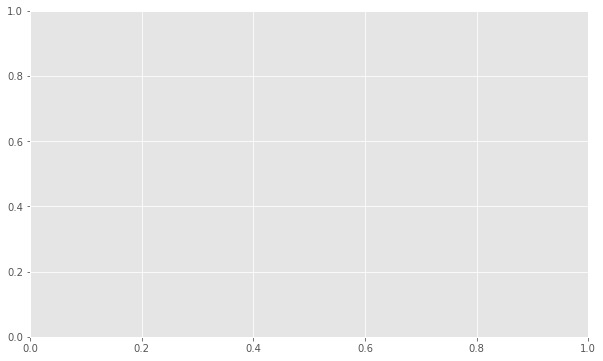

In [84]:
plt.figure(figsize=(10, 6))
plt.boxplot(MCCs, labels=n_features)
plt.ylabel("MCC")
plt.xlabel("Features");

In [85]:
train_data, test_data, train_labels, test_labels = train_test_split(best_features, active, test_size=0.25, random_state=42, stratify=active)

C=0.01, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.01, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.0

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.01373823795883263, gamma=0.7880462815669912
NER

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.018873918221350976, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.018873918221350976, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.02592943797404667, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.02592943797404667, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.02592943797404667, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.02592943797404667, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.02592943797404667, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.02592943797404667, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: na

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.035622478902624426, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.035622478902624426, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553,

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.04893900918477494, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.04893900918477494, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.04893900918477494, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.04893900918477494, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.04893900918477494, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.04893900918477494, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MC

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.06723357536499334, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.06723357536499334, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MC

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.09236708571873861, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.09236708571873861, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.09236708571873861, gamma=0.4893900918477494
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.09236708571873861, gamma=0.6210169418915616
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.09236708571873861, gamma=0.7880462815669912
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.09236708571873861, gamma=1.0
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.12689610031679222, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.12689610031679222, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan
C=0.12689610031679222

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.12689610031679222, gamma=0.18873918221350977
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.12689610031679222, gamma=0.2395026619987486
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.12689610031679222, gamma=0.3039195382313198
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.12689610031679222, gamma=0.38566204211634725
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.12689610031679222, gamma=0.4893900918477494
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.12689610031679222, gamma=0.6210169418915616
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, M

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.17433288221999882, gamma=0.11721022975334805
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.17433288221999882, gamma=0.14873521072935117
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.17433288221999882, gamma=0.18873918221350977
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.17433288221999882, gamma=0.2395026619987486
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.17433288221999882, gamma=0.3039195382313198
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.17433288221999882, gamma=0.38566204211634725
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589,

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.2395026619987486, gamma=0.0727895384398315
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.2395026619987486, gamma=0.09236708571873861
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.2395026619987486, gamma=0.11721022975334805
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.2395026619987486, gamma=0.14873521072935117
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.2395026619987486, gamma=0.18873918221350977
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.2395026619987486, gamma=0.2395026619987486
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.32903445623126676, gamma=0.04520353656360243
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.32903445623126676, gamma=0.057361525104486784
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.32903445623126676, gamma=0.0727895384398315
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.32903445623126676, gamma=0.09236708571873861
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.32903445623126676, gamma=0.11721022975334805
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.32903445623126676, gamma=0.14873521072935117
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.58

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.4520353656360243, gamma=0.035622478902624426
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.4520353656360243, gamma=0.04520353656360243
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.4520353656360243, gamma=0.057361525104486784
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.4520353656360243, gamma=0.0727895384398315
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.4520353656360243, gamma=0.09236708571873861
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.4520353656360243, gamma=0.11721022975334805
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MC

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.6210169418915616, gamma=0.02807216203941177
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.6210169418915616, gamma=0.035622478902624426
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.6210169418915616, gamma=0.04520353656360243
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.6210169418915616, gamma=0.057361525104486784
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.6210169418915616, gamma=0.0727895384398315
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.6210169418915616, gamma=0.09236708571873861
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MC

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=0.8531678524172805, gamma=0.022122162910704492
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.8531678524172805, gamma=0.02807216203941177
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.8531678524172805, gamma=0.035622478902624426
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.8531678524172805, gamma=0.04520353656360243
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.8531678524172805, gamma=0.057361525104486784
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=0.8531678524172805, gamma=0.0727895384398315
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, M

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=1.1721022975334805, gamma=0.017433288221999882
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.1721022975334805, gamma=0.022122162910704492
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.1721022975334805, gamma=0.02807216203941177
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.1721022975334805, gamma=0.035622478902624426
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.1721022975334805, gamma=0.04520353656360243
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.1721022975334805, gamma=0.057361525104486784
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589,

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encou

C=1.6102620275609392, gamma=0.010826367338740546
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.6102620275609392, gamma=0.01373823795883263
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.6102620275609392, gamma=0.017433288221999882
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.6102620275609392, gamma=0.022122162910704492
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.6102620275609392, gamma=0.02807216203941177
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=1.6102620275609392, gamma=0.035622478902624426
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589,

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=2.212216291070448, gamma=0.006723357536499335
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=2.212216291070448, gamma=0.008531678524172805
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=2.212216291070448, gamma=0.010826367338740546
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=2.212216291070448, gamma=0.01373823795883263
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=2.212216291070448, gamma=0.017433288221999882
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=2.212216291070448, gamma=0.022122162910

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=3.039195382313198, gamma=0.0041753189365604
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=3.039195382313198, gamma=0.005298316906283708
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=3.039195382313198, gamma=0.006723357536499335
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=3.039195382313198, gamma=0.008531678524172805
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=3.039195382313198, gamma=0.010826367338740546
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=3.039195382313198, gamma=0.0137382379588

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=4.175318936560401, gamma=0.0041753189365604
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=4.175318936560401, gamma=0.005298316906283708
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=4.175318936560401, gamma=0.006723357536499335
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=4.175318936560401, gamma=0.008531678524172805
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=4.175318936560401, gamma=0.010826367338740546
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=4.175318936560401, gamma=0.01373823795883263
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0

<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-39-d75c9e15214a>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=5.736152510448681, gamma=0.005298316906283708
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=5.736152510448681, gamma=0.006723357536499335
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=5.736152510448681, gamma=0.008531678524172805
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=5.736152510448681, gamma=0.010826367338740546
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=5.736152510448681, gamma=0.01373823795883263
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC: 0.163
C=5.736152510448681, gamma=0.017433288221999882
NER: 0.581, Sensitivity or recall: 0.654, Specificity: 0.508, Precision: 0.622, Correctly classified: 0.589, MCC:

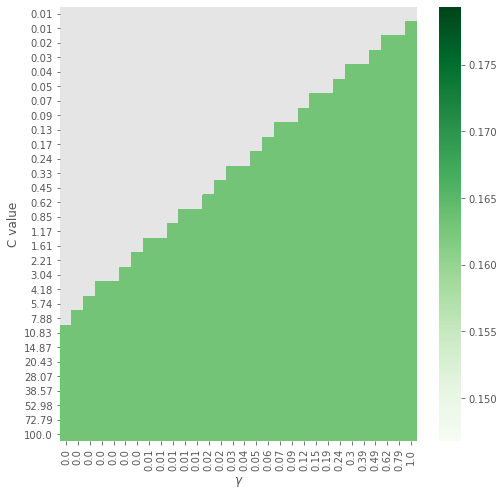

In [86]:
grid_search_SVM(train_data, test_data, train_labels, test_labels)

In [87]:
C=3.039195382313198
gamma=0.005298316906283708
svm_obj = SVC(C=C, kernel="rbf", gamma=gamma, class_weight="balanced")
MCC_val_all, MCC_test_all, acc_val_all, acc_test_all = run_cross_validation(best_features, active, folds=10, clf=svm_obj, verbose=False)

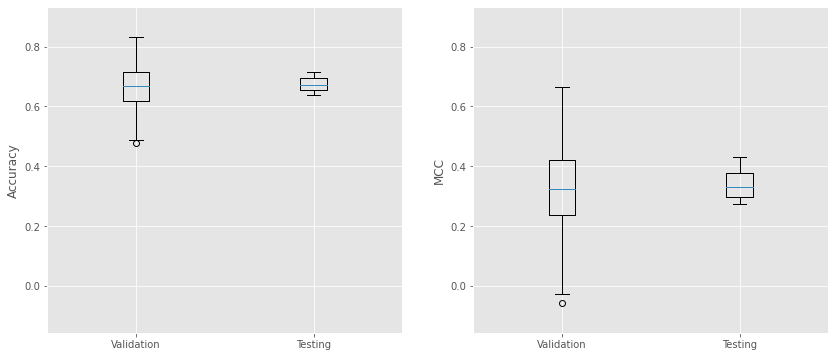

In [88]:
plot_results_CV(MCC_val_all, MCC_test_all, acc_val_all, acc_test_all)

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [90]:
train_data, test_data, train_labels, test_labels = train_test_split(joined_features, active, test_size=0.25, random_state=42, stratify=active)

NER: 0.773, Sensitivity or recall: 0.974, Specificity: 0.571, Precision: 0.738, Correctly classified: 0.794, MCC: 0.612


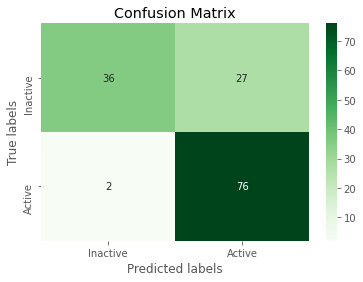

In [91]:
C= 0.788046
gamm = 0.0239502
svm = SVC(C=C, kernel="rbf", gamma=gamm, class_weight="balanced")
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = GaussianNB()
eclf1 = VotingClassifier(estimators=[('svm', svm), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1.fit(train_data, train_labels)
predictions = eclf1.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

In [92]:
MCC_val_vote, MCC_test_vote, acc_val_vote, acc_test_vote = run_cross_validation(best_features, active, folds=10, clf=eclf1, verbose=False)

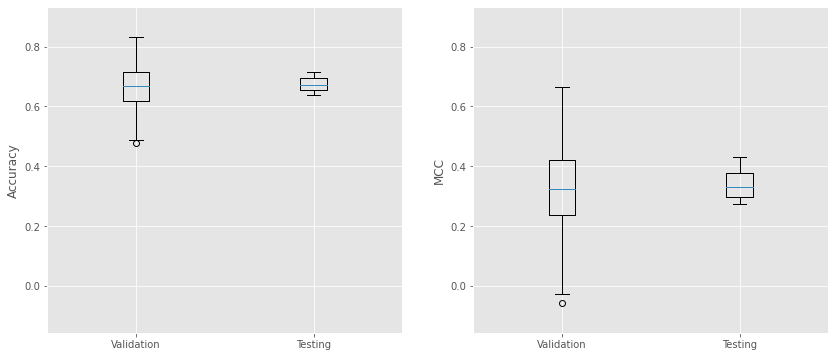

In [93]:
plot_results_CV(MCC_val_vote, MCC_test_vote, acc_val_vote, acc_test_vote)